# The h2o notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features
- y-sets are normalized (MinMax)
- Removes repeated values in y-set B and C

It takes over from feature_engineering_1
Adds some ratio features from feature_engineering_3

**Takes over from cleaning_1_median.ipynb**


### Whats new?
takes over from best noteook, test on h2o

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

## Handling the Y-set

In [3]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [4]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


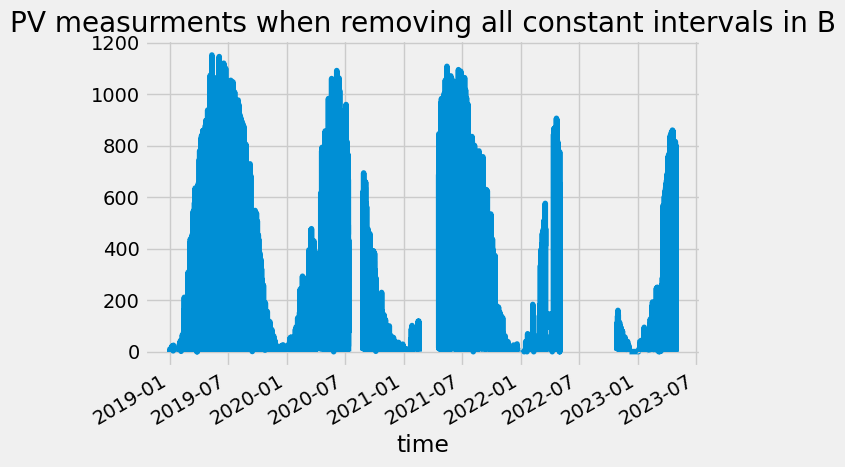

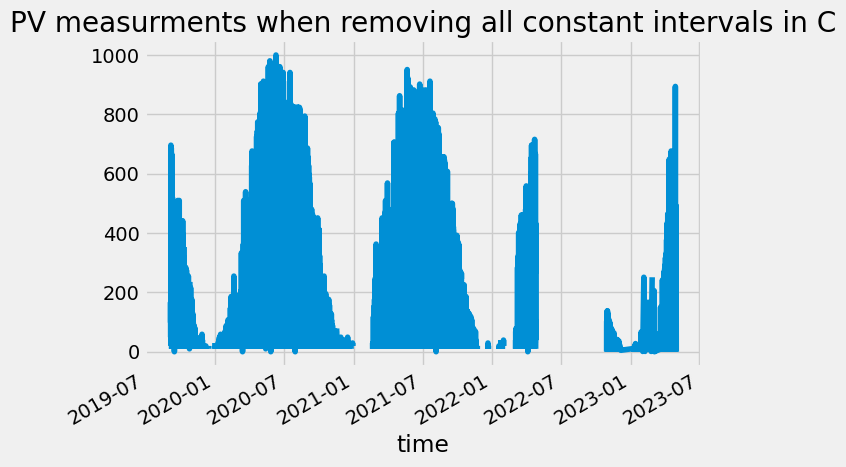

In [5]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [6]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [8]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [9]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [10]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [11]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').median()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').median()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').median()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').median()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').median()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').median()


In [12]:
X_train_observed_a.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10

In [13]:
f = 'air_density_2m:kgm3'

In [14]:
def replace_outliers_with_nan(df, feature):
    '''Replaces thr 0.01 and 0.99'''
    Q1 = df[feature].quantile(0.01)
    Q99 = df[feature].quantile(0.99)
    #median_value = df[feature].median()

    df[feature] = np.where(
        (df[feature] < Q1) | (df[feature] > Q99),
        np.nan,
        df[feature]
    )

In [15]:
outliers = ['air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa']

# 'air_density_2m:kgm3', 'msl_pressure:hPa', 'sfc_pressure:hPa', 'wind_speed_10m:ms',
# 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'

#0.04391554145075651

for o in outliers:
    replace_outliers_with_nan(X_train_observed_a, o)
    replace_outliers_with_nan(X_train_observed_b, o)
    replace_outliers_with_nan(X_train_observed_c, o)

In [16]:
#median = X_train_observed_a['air_density_2m:kgm3'].median()

#outliers_indices = (X_train_observed_a['air_density_2m:kgm3'] < 1.15) | (X_train_observed_a['air_density_2m:kgm3'] > 1.41)
#X_train_observed_a.loc[outliers_indices, 'air_density_2m:kgm3'] = np.nan
#X_train_observed_a['air_density_2m:kgm3'].interpolate(method='spline', order=3, inplace=True)
#X_train_observed_a[f].plot(style='o')

In [17]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [18]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

One hot encoding on location

In [19]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [20]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,0.0,278.250000,87.500000,16823.399902,2.80,1.20,2.55,-0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,0.0,278.349991,85.350002,16512.299805,2.90,1.10,2.65,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,0.0,278.200012,99.099998,13277.399902,3.65,1.40,3.35,-0.0,0,NaT
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,0.0,278.100006,99.099998,12777.449707,3.55,1.50,3.20,-0.0,0,NaT
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,0.1,278.050003,97.849998,11142.549805,4.05,2.15,3.45,-0.0,0,NaT


In [21]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    df['ratio_clear_sky_rad_to_cloud_cover'] = df['clear_sky_rad:W'] / (df['effective_cloud_cover:p'] + 1e-8)  # added a small number to avoid division by zero

    df['ratio_direct_to_diffuse_rad'] = df['direct_rad:W'] / (df['diffuse_rad:W'] + 1e-8)

    df['ratio_air_density_to_humidity'] = df['air_density_2m:kgm3'] / (df['absolute_humidity_2m:gm3'] + 1e-8)

    df['ratio_wind_speed_10m_to_1000hPa'] = df['wind_speed_v_10m:ms'] / (df['wind_speed_w_1000hPa:ms'] + 1e-8)

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover,ratio_clear_sky_rad_to_cloud_cover,ratio_direct_to_diffuse_rad,ratio_air_density_to_humidity,ratio_wind_speed_10m_to_1000hPa
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,5.55,1.2395,1200.700012,0.0,0.0,1200.700012,...,3,0,0.934996,0.354658,-0.0,0.0,0.0,0.0,0.223333,2.550000e+08
2019-01-01 00:00:00,NaN,0,0,1,5.45,1.2410,1130.049988,0.0,0.0,1130.049988,...,3,0,0.934934,0.354821,-0.0,0.0,0.0,0.0,0.227706,2.650000e+08
2019-01-01 01:00:00,NaN,0,0,1,5.35,1.2400,1066.699951,0.0,0.0,1066.699951,...,3,0,0.761584,0.648067,-0.0,0.0,0.0,0.0,0.231776,3.350000e+08
2019-01-01 01:00:00,NaN,0,1,0,5.40,1.2395,1131.449951,0.0,0.0,1131.449951,...,3,0,0.761815,0.647794,-0.0,0.0,0.0,0.0,0.229537,3.200000e+08
2019-01-01 02:00:00,NaN,0,1,0,5.40,1.2385,1061.049988,0.0,0.0,1061.049988,...,3,0,0.531894,0.846811,-0.0,0.0,0.0,0.0,0.229352,3.450000e+08


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [22]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [23]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [24]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3       72
air_density_2m:kgm3          1824
clear_sky_energy_1h:J          72
clear_sky_rad:W                72
dew_or_rime:idx                72
                            ...  
location_A                      0
location_B                      0
location_C                      0
estimated                       0
pv_measurement              43484
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 45327 ROWS BEING DROPPED. THE DATASET HAS 53759 ROWS IN TOTAL.


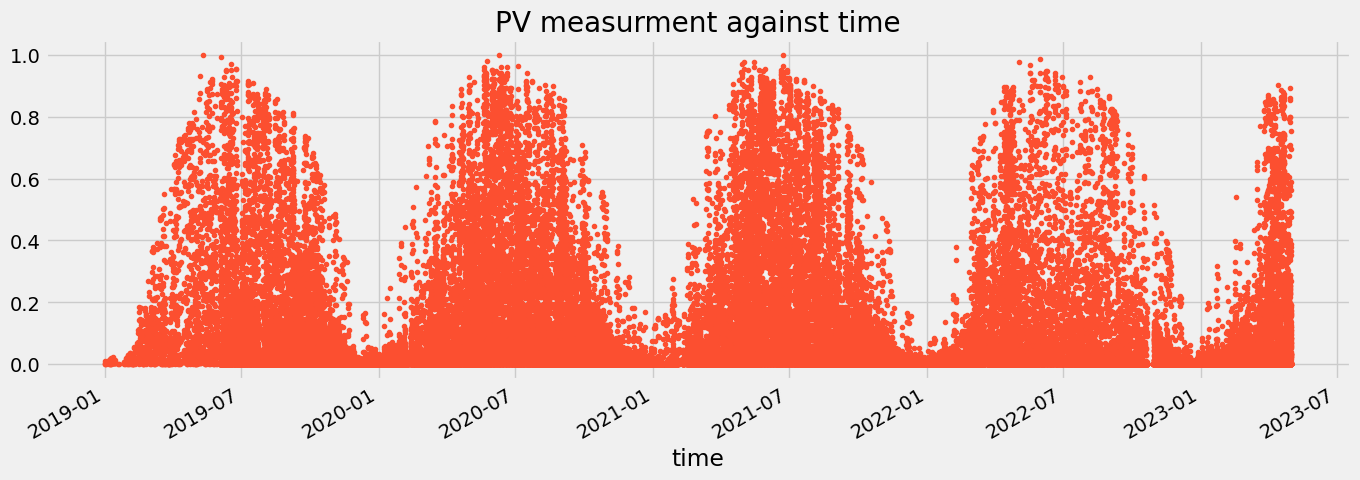

In [25]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)
    x_test['estimated'] = 1

    x_test = x_test.resample('60min').median()

    x_test = create_features(x_test)

    if location == 'A':
        x_test['location_A'] =  1
        x_test['location_B'] = 0
        x_test['location_C'] = 0
    elif location == 'B':
        x_test['location_A'] =  0
        x_test['location_B'] = 1
        x_test['location_C'] = 0
    elif location == 'C':
        x_test['location_A'] =  0
        x_test['location_B'] = 0
        x_test['location_C'] = 1

    return x_test

In [27]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [28]:
test_sub = pd.read_csv('../../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [29]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_b.loc[valid_dates]
x_test_c = x_test_c.loc[valid_dates]

In [30]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

In [31]:
X_test_kaggle = X_test.copy()

### Disability Check

Check if the training data and the test data contains the same columns.

In [32]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [33]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [34]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import h2o
from h2o.automl import H2OAutoML
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "18.0.1.1" 2022-04-22; Java(TM) SE Runtime Environment (build 18.0.1.1+2-6); Java HotSpot(TM) 64-Bit Server VM (build 18.0.1.1+2-6, mixed mode, sharing)
  Starting server from /Users/nickaskari/Machinelearning/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/tmpsxii9s2x
  JVM stdout: /var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/tmpsxii9s2x/h2o_nickaskari_started_from_python.out
  JVM stderr: /var/folders/h4/_4wngf5n4793mylk022tqrrh0000gn/T/tmpsxii9s2x/h2o_nickaskari_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_nickaskari_t395on
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [35]:
hf = h2o.H2OFrame(df)
hf_test = h2o.H2OFrame(X_test) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [36]:
y = "pv_measurement"
x = hf.columns
x.remove(y)

In [37]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(seed=1, nfolds=5)  
aml.train(x=x, y=y, training_frame=hf)

AutoML progress: |
15:13:27.725: AutoML: XGBoost is not available; skipping it.
15:13:27.751: _train param, Dropping bad and constant columns: [snow_drift:idx]

█
15:13:30.50: _train param, Dropping bad and constant columns: [snow_drift:idx]

██████████████
15:15:21.412: _train param, Dropping unused columns: [snow_drift:idx]
15:15:22.126: _train param, Dropping bad and constant columns: [snow_drift:idx]

████
15:17:30.453: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
15:18:40.52: _train param, Dropping bad and constant columns: [snow_drift:idx]

████
15:19:52.450: _train param, Dropping bad and constant columns: [snow_drift:idx]

███
15:21:07.640: _train param, Dropping unused columns: [snow_drift:idx]
15:21:08.178: _train param, Dropping unused columns: [snow_drift:idx]


15:21:09.518: _train param, Dropping bad and constant columns: [snow_drift:idx]

█████
15:23:27.141: _train param, Dropping bad and constant columns: [snow_drift:idx]

██
15:24:35.795: _trai

key,value
Stacking strategy,cross_validation
Number of base models (used / total),64/64
# GBM base models (used / total),48/48
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),13/13
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [38]:
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

model_id                                                      rmse         mse        mae        rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_1_20231027_151327     0.0480572  0.0023095   0.0234214    0.0355783                0.0023095
StackedEnsemble_AllModels_3_AutoML_1_20231027_151327     0.0497326  0.00247333  0.0245819    0.0369918                0.00247333
StackedEnsemble_AllModels_4_AutoML_1_20231027_151327     0.0497363  0.0024737   0.0245841    0.0369947                0.0024737
StackedEnsemble_AllModels_6_AutoML_1_20231027_151327     0.0497386  0.00247393  0.0245366    0.0369905                0.00247393
StackedEnsemble_Best1000_1_AutoML_1_20231027_151327      0.0497401  0.00247408  0.0245827    0.0369961                0.00247408
StackedEnsemble_BestOfFamily_5_AutoML_1_20231027_151327  0.0507642  0.002577    0.0248935    0.0376251                0.002577
StackedEnsemble_BestOfFamily_4_AutoML_1_20231027_151327  0.0509957  0.00260057  0.0252815    0.037919

### Predict and make csv

In [39]:
predictions = aml.leader.predict(hf_test)  

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [40]:
predictions = h2o.as_list(predictions)

In [41]:
predictions.rename(columns={'predict': 'prediction'}, inplace=True)

predictions.head()

,prediction
0,0.001563
1,0.001563
2,0.001563
3,0.010100
4,0.071202


In [42]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [43]:

n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))


In [44]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [45]:
predictions.head(100)

,prediction
0,8.962116
1,8.962116
2,8.962116
3,57.908840
4,408.228236
...,...
95,8.962116
96,8.962116
97,8.962116
98,47.656408


In [46]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [47]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

Redifing the training sets

In [48]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

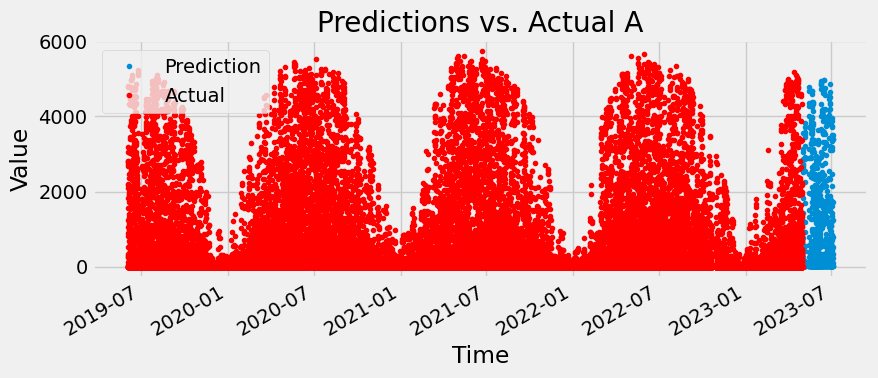

In [49]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

### Plotting B

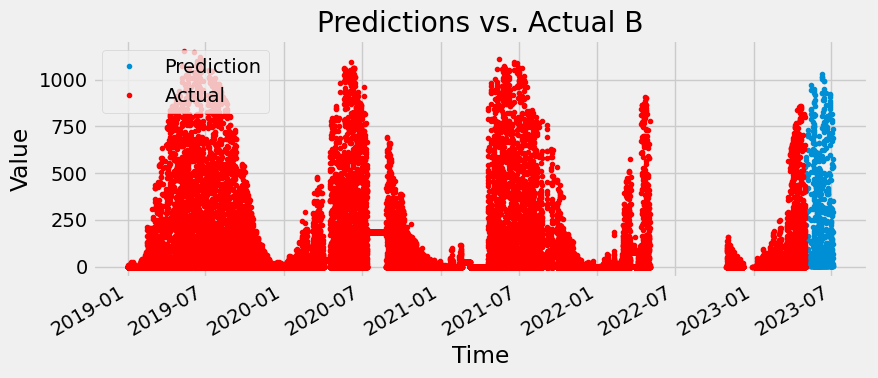

In [50]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


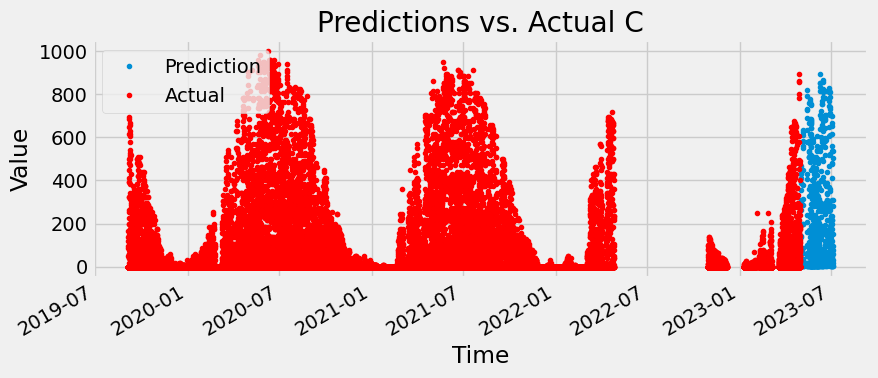

In [51]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

## PREVIOUS ATTEMPT

In [52]:
''' 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {
    'colsample_bytree': [0.3],
    'learning_rate': [0.01],
    'max_depth': [6],
    'n_estimators': [1000],
}

# OPTIMAL Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, scoring='neg_mean_absolute_error', param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb_model = grid_search.best_estimator_

# Get feature importances from this best model
feature_importances = best_xgb_model.feature_importances_
'''

" \nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\nfrom xgboost import XGBRegressor\nimport warnings\nwarnings.filterwarnings('ignore', category=FutureWarning)\n\n\ncv_split = TimeSeriesSplit(n_splits=5)\nmodel = XGBRegressor()\n\nparameters = {\n    'colsample_bytree': [0.3],\n    'learning_rate': [0.01],\n    'max_depth': [6],\n    'n_estimators': [1000],\n}\n\n# OPTIMAL Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}\n\nX_train = df[FEATURES]\ny_train = df[TARGET]\n\ngrid_search = GridSearchCV(estimator=model, cv=cv_split, scoring='neg_mean_absolute_error', param_grid=parameters, verbose=2)\ngrid_search.fit(X_train, y_train)\n\n# Get the best estimator\nbest_xgb_model = grid_search.best_estimator_\n\n# Get feature importances from this best model\nfeature_importances = best_xgb_model.feature_importances_\n"